In [4]:
from pathlib import Path
import pandas as pd

BASE = Path("..").resolve()
RAW = BASE / "data" / "raw" / "fbref" / "epl_2024-2025"

list(RAW.glob("*.csv"))

[PosixPath('/Users/kekc/Projects/GIT/sports-stats-analysis/data/raw/fbref/epl_2024-2025/schedule_results.csv'),
 PosixPath('/Users/kekc/Projects/GIT/sports-stats-analysis/data/raw/fbref/epl_2024-2025/team_standard_stats.csv'),
 PosixPath('/Users/kekc/Projects/GIT/sports-stats-analysis/data/raw/fbref/epl_2024-2025/standings.csv')]

In [5]:
# Загружаем три исходных CSV
standings = pd.read_csv(RAW / "standings.csv")
team_stats = pd.read_csv(RAW / "team_standard_stats.csv")
fixtures = pd.read_csv(RAW / "schedule_results.csv")

print("Standings:", standings.shape)
print("Team stats:", team_stats.shape)
print("Fixtures:", fixtures.shape)

standings.head(3)

Standings: (20, 19)
Team stats: (20, 32)
Fixtures: (391, 14)


,rk,squad,mp,w,d,l,gf,ga,gd,pts,pts_mp,xg,xga,xgd,xgd_90,attendance,top_team_scorer,goalkeeper,notes
0,1,Liverpool,38,25,9,4,86,41,45,84,2.21,82.2,38.6,43.6,1.15,60324,Mohamed Salah - 29,Alisson,→ Champions League via league finish
1,2,Arsenal,38,20,14,4,69,34,35,74,1.95,59.9,34.4,25.5,0.67,60251,Kai Havertz - 9,David Raya,→ Champions League via league finish
2,3,Manchester City,38,21,8,9,72,44,28,71,1.87,68.1,47.7,20.4,0.54,52756,Erling Haaland - 22,Ederson,→ Champions League via league finish


In [6]:
print("🟦 Standings columns:")
display(standings.dtypes.to_frame("dtype").T)

print("\n🟩 Team stats columns:")
display(team_stats.dtypes.to_frame("dtype").T)

print("\n🟨 Fixtures columns:")
display(fixtures.dtypes.to_frame("dtype").T)

🟦 Standings columns:


,rk,squad,mp,w,d,l,gf,ga,gd,pts,pts_mp,xg,xga,xgd,xgd_90,attendance,top_team_scorer,goalkeeper,notes
dtype,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,object,object,object



🟩 Team stats columns:


,squad,pl,age,poss,mp,starts,min,90s,gls,ast,...,gls_per90,ast_per90,g_plus_a_per90,g_pk_per90,g_plus_a_pk_per90,xg_per90,xag_per90,xg_xag_per90,npxg_per90,npxg_xag_per90
dtype,object,int64,float64,float64,int64,int64,int64,float64,int64,int64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64



🟨 Fixtures columns:


,wk,day,date,time,home,xg,score,xg_1,away,attendance,venue,referee,match_report,notes
dtype,object,object,object,object,object,object,object,object,object,object,object,object,object,object


In [7]:
def na_report(df: pd.DataFrame, name: str):
    na = df.isna().sum()
    na = na[na > 0]
    if na.empty:
        print(f"{name}: пропусков нет ✅")
    else:
        print(f"{name}: найдено {len(na)} колонок с пропусками")
        display(na.sort_values(ascending=False))

na_report(standings, "standings")
na_report(team_stats, "team_standard_stats")
na_report(fixtures, "fixtures")

standings: найдено 1 колонок с пропусками


notes    8
dtype: int64

team_standard_stats: пропусков нет ✅
fixtures: найдено 1 колонок с пропусками


notes    380
dtype: int64

In [8]:
# Удаляем колонку 'notes', если есть
for df in [standings, team_stats, fixtures]:
    if "notes" in df.columns:
        df.drop(columns=["notes"], inplace=True)

# Приводим имена колонок к нижнему регистру и убираем лишние символы
def clean_columns(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("%", "pct")
        .str.replace("/", "_")
        .str.replace("-", "_", regex=False)
    )
    return df

standings = clean_columns(standings)
team_stats = clean_columns(team_stats)
fixtures = clean_columns(fixtures)

print("Очистка завершена ✅")
print("Standings cols:", len(standings.columns))
print("Team stats cols:", len(team_stats.columns))
print("Fixtures cols:", len(fixtures.columns))

Очистка завершена ✅
Standings cols: 18
Team stats cols: 32
Fixtures cols: 13


In [9]:
# проверим совпадение команд между standings и team_stats, чтобы убедиться, что потом можно будет безопасно объединять их
squads_s = set(standings["squad"])
squads_t = set(team_stats["squad"])

print("Команд в standings:", len(squads_s))
print("Команд в team_stats:", len(squads_t))
print("Разница (только в standings):", squads_s - squads_t)
print("Разница (только в team_stats):", squads_t - squads_s)

Команд в standings: 20
Команд в team_stats: 20
Разница (только в standings): set()
Разница (только в team_stats): set()


In [10]:
# выбираем только числовые колонки
num_cols = team_stats.select_dtypes(include=["number"]).columns

# описательная статистика
team_stats[num_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
pl,20.0,28.70,3.39,23.00,26.00,29.00,31.25,36.00
age,20.0,26.26,1.20,23.70,25.42,26.15,27.05,28.10
poss,20.0,50.00,5.93,40.60,47.28,49.50,53.80,61.30
mp,20.0,38.00,0.00,38.00,38.00,38.00,38.00,38.00
starts,20.0,418.00,0.00,418.00,418.00,418.00,418.00,418.00
min,20.0,3420.00,0.00,3420.00,3420.00,3420.00,3420.00,3420.00
90s,20.0,38.00,0.00,38.00,38.00,38.00,38.00,38.00
gls,20.0,54.10,14.62,25.00,42.75,56.50,64.25,85.00
ast,20.0,40.20,11.80,16.00,29.00,42.00,47.00,65.00
g_plus_a,20.0,94.30,26.22,41.00,71.75,98.50,108.25,150.00


In [11]:
# добавим очки (pts) из standings в team_stats
if "pts" in standings.columns:
    merged = team_stats.merge(standings[["squad", "pts"]], on="squad", how="left")
else:
    merged = team_stats.copy()

# выберем ключевые числовые поля для корреляции
corr_cols = [c for c in ["pts", "poss", "xg", "xga", "gls", "ast", "g_plus_a_per90"] if c in merged.columns]

corr_matrix = merged[corr_cols].corr().round(2)
display(corr_matrix)

,pts,poss,xg,gls,ast,g_plus_a_per90
pts,1.00,0.52,0.84,0.89,0.88,0.89
poss,0.52,1.00,0.68,0.64,0.64,0.64
xg,0.84,0.68,1.00,0.90,0.86,0.89
gls,0.89,0.64,0.90,1.00,0.97,0.99
ast,0.88,0.64,0.86,0.97,1.00,0.99
g_plus_a_per90,0.89,0.64,0.89,0.99,0.99,1.00


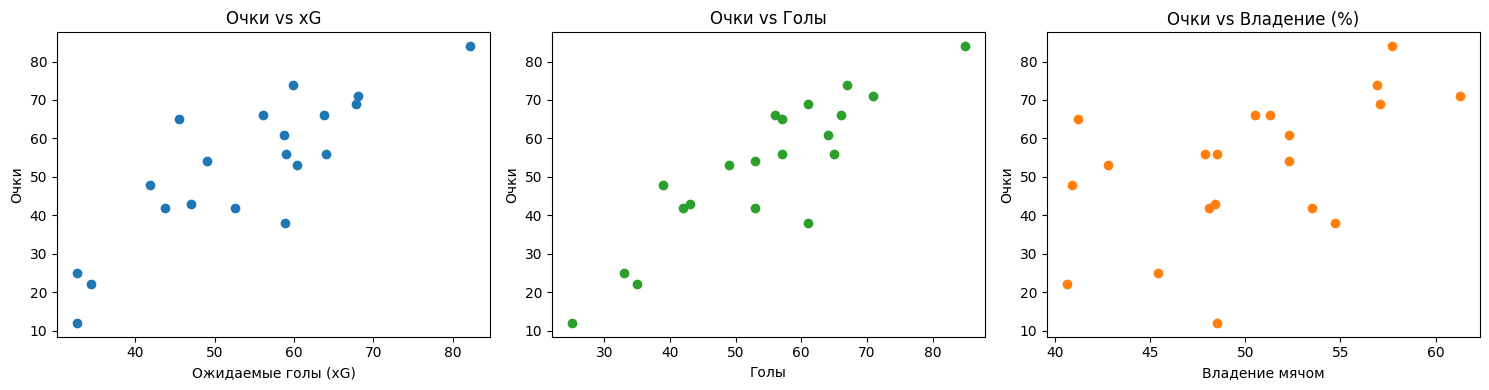

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(merged["xg"], merged["pts"], color="tab:blue")
axes[0].set_title("Очки vs xG")
axes[0].set_xlabel("Ожидаемые голы (xG)")
axes[0].set_ylabel("Очки")

axes[1].scatter(merged["gls"], merged["pts"], color="tab:green")
axes[1].set_title("Очки vs Голы")
axes[1].set_xlabel("Голы")
axes[1].set_ylabel("Очки")

axes[2].scatter(merged["poss"], merged["pts"], color="tab:orange")
axes[2].set_title("Очки vs Владение (%)")
axes[2].set_xlabel("Владение мячом")
axes[2].set_ylabel("Очки")

plt.tight_layout()
plt.show()

In [13]:
import re
import numpy as np

fx = fixtures.copy()

# определяем колонки с командами и счётом
home_col = "home" if "home" in fx.columns else [c for c in fx.columns if c.startswith("home")][0]
away_col = "away" if "away" in fx.columns else [c for c in fx.columns if c.startswith("away")][0]
score_col = "score" if "score" in fx.columns else [c for c in fx.columns if "score" in c][0]

# парсим счёт вида "2–1" или "2-1"
def parse_score(s):
    if pd.isna(s):
        return np.nan, np.nan
    m = re.search(r"(\d+)\s*[–-]\s*(\d+)", str(s))
    return (int(m.group(1)), int(m.group(2))) if m else (np.nan, np.nan)

fx[["home_goals", "away_goals"]] = fx[score_col].apply(lambda s: pd.Series(parse_score(s)))
fx = fx.dropna(subset=["home_goals", "away_goals"]).copy()  # ← учитываем только сыгранные матчи

# результат (W/L/D) для хозяев и гостей
fx["home_result"] = np.where(fx["home_goals"] > fx["away_goals"], "W",
                      np.where(fx["home_goals"] < fx["away_goals"], "L", "D"))
fx["away_result"] = np.where(fx["away_goals"] > fx["home_goals"], "W",
                      np.where(fx["away_goals"] < fx["home_goals"], "L", "D"))

# группировка и winrate
home = fx.groupby(home_col)["home_result"].value_counts().unstack(fill_value=0)
home["home_games"] = home.sum(axis=1)
home["home_winrate"] = (home.get("W", 0) / home["home_games"]).round(3)

away = fx.groupby(away_col)["away_result"].value_counts().unstack(fill_value=0)
away["away_games"] = away.sum(axis=1)
away["away_winrate"] = (away.get("W", 0) / away["away_games"]).round(3)

# объединяем
winrates = (
    pd.DataFrame({"squad": home.index, "home_winrate": home["home_winrate"].values})
    .merge(pd.DataFrame({"squad": away.index, "away_winrate": away["away_winrate"].values}),
           on="squad", how="outer")
)
winrates["overall_winrate"] = winrates[["home_winrate", "away_winrate"]].mean(axis=1).round(3)

winrates.sort_values("overall_winrate", ascending=False).reset_index(drop=True).head(10)

,squad,home_winrate,away_winrate,overall_winrate
0,Liverpool,0.737,0.579,0.658
1,Manchester City,0.684,0.421,0.552
2,Arsenal,0.579,0.474,0.526
3,Chelsea,0.632,0.421,0.526
4,Newcastle Utd,0.632,0.421,0.526
5,Nott'ham Forest,0.474,0.526,0.500
6,Aston Villa,0.579,0.421,0.500
7,Brentford,0.474,0.368,0.421
8,Brighton,0.421,0.421,0.421
9,Bournemouth,0.421,0.368,0.394


In [14]:
# объединяем таблицы
summary = (
    standings[["squad", "pts"]]
    .merge(team_stats[["squad", "xg", "poss"]], on="squad", how="left")
    .merge(winrates, on="squad", how="left")
)

# считаем корреляции между ключевыми показателями
corr_summary = summary[["pts", "xg", "poss", "home_winrate", "away_winrate", "overall_winrate"]].corr().round(2)
corr_summary

,pts,xg,poss,home_winrate,away_winrate,overall_winrate
pts,1.00,0.84,0.52,0.95,0.96,0.99
xg,0.84,1.00,0.68,0.86,0.75,0.85
poss,0.52,0.68,1.00,0.67,0.37,0.57
home_winrate,0.95,0.86,0.67,1.00,0.84,0.97
away_winrate,0.96,0.75,0.37,0.84,1.00,0.94
overall_winrate,0.99,0.85,0.57,0.97,0.94,1.00


In [20]:
# создадим ранжирование по ключевым метрикам
rank_cols = ["pts", "xg", "poss", "overall_winrate"]

# нормализуем каждую из них (от 0 до 1)
for col in rank_cols:
    summary[f"{col}_norm"] = (summary[col] - summary[col].min()) / (summary[col].max() - summary[col].min())

# создаём общий рейтинг силы (равновесная средняя)
summary["team_strength"] = summary[[f"{c}_norm" for c in rank_cols]].mean(axis=1).round(3)

# выведем топ-10 и аутсайдеров
print("🏆 Топ-10 команд по совокупной силе:")
display(summary.sort_values("team_strength", ascending=False).head(10)[["squad", "pts", "xg", "poss", "overall_winrate", "team_strength"]])

print("\n⚠️ Аутсайдеры (низкий совокупный рейтинг):")
display(summary.sort_values("team_strength", ascending=True).head(5)[["squad", "pts", "xg", "poss", "overall_winrate", "team_strength"]])

🏆 Топ-10 команд по совокупной силе:


,squad,pts,xg,poss,overall_winrate,team_strength
0,Liverpool,84,82.2,57.7,0.658,0.957
2,Manchester City,71,68.1,61.3,0.552,0.840
3,Chelsea,69,67.8,57.1,0.526,0.770
1,Arsenal,74,59.9,56.9,0.526,0.745
4,Newcastle Utd,66,63.8,51.3,0.526,0.669
5,Aston Villa,66,56.1,50.5,0.500,0.610
7,Brighton,61,58.7,52.3,0.421,0.595
8,Bournemouth,56,64.0,48.5,0.394,0.547
9,Brentford,56,59.0,47.9,0.421,0.526
10,Fulham,54,49.0,52.3,0.394,0.511



⚠️ Аутсайдеры (низкий совокупный рейтинг):


,squad,pts,xg,poss,overall_winrate,team_strength
18,Ipswich Town,22,34.4,40.6,0.106,0.066
19,Southampton,12,32.7,48.5,0.053,0.096
17,Leicester City,25,32.6,45.4,0.158,0.146
12,Everton,48,41.8,40.9,0.290,0.273
15,Wolves,42,43.7,48.1,0.316,0.359


📊 Корреляции с совокупной силой команды:


team_strength      1.00
xg                 0.94
overall_winrate    0.94
goal_balance       0.94
pts                0.93
poss               0.78
Name: team_strength, dtype: float64

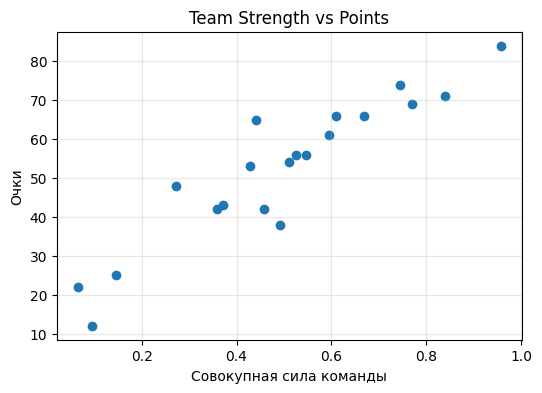

In [21]:
# корреляция силы команды с другими метриками
corr_strength = summary[["team_strength", "pts", "xg", "poss", "overall_winrate", "goal_balance"]].corr().round(2)

print("📊 Корреляции с совокупной силой команды:")
display(corr_strength["team_strength"].sort_values(ascending=False))

# визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(summary["team_strength"], summary["pts"], color="tab:blue")
plt.title("Team Strength vs Points")
plt.xlabel("Совокупная сила команды")
plt.ylabel("Очки")
plt.grid(alpha=0.3)
plt.show()

,xg,poss,overall_winrate,goal_balance
cluster,,,,
0,53.05,48.42,0.37,-1.58
1,68.36,56.86,0.56,28.20
2,33.23,44.83,0.11,-51.67


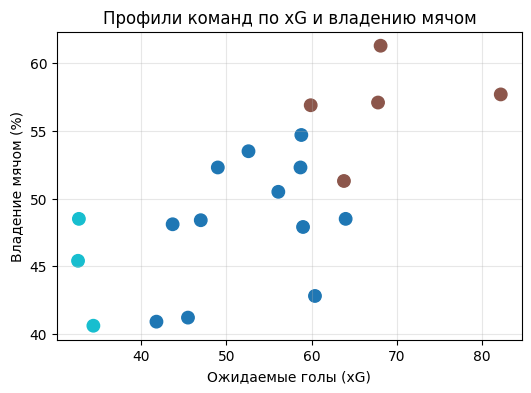

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# выбираем ключевые признаки для кластеризации
features = ["xg", "poss", "overall_winrate", "goal_balance"]

# стандартизируем
scaler = StandardScaler()
X = scaler.fit_transform(summary[features])

# кластеризация (3 кластера для примера)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
summary["cluster"] = kmeans.fit_predict(X)

# усреднённые профили кластеров
cluster_summary = summary.groupby("cluster")[features].mean().round(2)
display(cluster_summary)

# визуализация распределения по кластерам
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(summary["xg"], summary["poss"], c=summary["cluster"], cmap="tab10", s=80)
plt.title("Профили команд по xG и владению мячом")
plt.xlabel("Ожидаемые голы (xG)")
plt.ylabel("Владение мячом (%)")
plt.grid(alpha=0.3)
plt.show()